# Matriculas:
Rafael Lopes Murta (690213)
Caio Massote Andrade (725728)
Henrique Moura Souza Belo (732218)
Guilherme Vedovelo de Britto Claro (738097)

In [46]:
soma_matriculas = 690213 + 725728 + 732218 + 738097
N2 = soma_matriculas % 2
N3 = soma_matriculas % 3
print(f'matriculas mod 2 = {N2} = Compacidade \nmatriculas mod 3 = {N3} = EfficientNet')

matriculas mod 2 = 0 = Compacidade 
matriculas mod 3 = 1 = EfficientNet


## Imports

In [47]:
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import itertools
import matplotlib.pyplot as plt
from os import makedirs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os
import tensorflow as tf
from scipy.spatial.distance import mahalanobis
from torchvision import transforms
from sklearn.covariance import EmpiricalCovariance
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization


## Create Directories and load data

In [ ]:
makedirs('train_test_images/train', exist_ok=True)
makedirs('train_test_images/test', exist_ok=True)
dir_list = ['scc', 'lsil', 'hsil', 'asc-h', 'asc-us', 'nfil']
for i in dir_list:
    makedirs(f'train_test_images/train/{i}', exist_ok=True)
    makedirs(f'train_test_images/test/{i}', exist_ok=True)

characteristics_df = pd.read_csv('characteristics.csv')

## Separate train and test images

In [ ]:
train, test = train_test_split(characteristics_df, test_size=0.2, random_state=42, shuffle=True, stratify=characteristics_df['bethesda_system'])

## Save train and test images on their respective folders

In [ ]:
def get_img_dir(bethesda_system, folder):
    if bethesda_system == 'SCC' or bethesda_system == 'LSIL' or bethesda_system == 'HSIL' or bethesda_system == 'ASC-H' or bethesda_system == 'ASC-US':
        return folder + '/' + bethesda_system.lower() + '/'
    elif bethesda_system == 'Negative for intraepithelial lesion':
        return folder + '/nfil/'

In [ ]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

for index, row in train.iterrows():
    imagepath = f'{get_img_dir(row["bethesda_system"], "editted_images")}{row["cell_id"]}.jpg'
    image = Image.open(imagepath)
    new_imagepath = f'{get_img_dir(row["bethesda_system"], "train_test_images/train")}{row["cell_id"]}.jpg'
    image.save(new_imagepath)

for index, row in test.iterrows():
    imagepath = f'{get_img_dir(row["bethesda_system"], "editted_images")}{row["cell_id"]}.jpg'
    image = Image.open(imagepath)
    new_imagepath = f'{get_img_dir(row["bethesda_system"], "train_test_images/test")}{row["cell_id"]}.jpg'
    image.save(new_imagepath)

## Distancia de Mahalanobis

In [40]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [41]:
train_data

,original_filename,cell_id,bethesda_system,area,perimeter,compactness,eccentricity,circularity,distance_from_original_nucleus
0,images/bef90ce102d8ea3841e78ed81d2d03ea.png,703,Negative for intraepithelial lesion,188.5,307.639609,39.954278,0.908039,0.025029,29.546573
1,images/df075c7d02cc7729bd04b5996a3e8991.png,11374,Negative for intraepithelial lesion,207.0,56.485281,1.226564,0.580135,0.815285,7.071068
2,images/6bb20c67c4013e8805d0f64315b9bcb1.png,8129,ASC-US,64.0,32.000000,1.273240,0.000000,0.785398,22.360680
3,images/eddca08930f139f44c5d22a48d9f2909.png,4407,Negative for intraepithelial lesion,631.0,99.112698,1.238852,0.659585,0.807199,12.806248
4,images/ed10d2a300c0f99915a467afc514c5cf.png,4712,Negative for intraepithelial lesion,150.5,52.242641,1.443125,0.715064,0.692941,5.385165
...,...,...,...,...,...,...,...,...,...
8667,images/33708abb81e40ff45d1510c44546e82f.png,10164,LSIL,323.0,470.391916,54.513908,0.763562,0.018344,15.000000
8668,images/ccfee7ab69cc4221156c47426b0e8ec8.png,7278,Negative for intraepithelial lesion,400.0,643.421354,82.360900,0.874194,0.012142,9.219544
8669,images/477a31e5481902c6624a3d0407be13bf.png,3179,Negative for intraepithelial lesion,498.5,94.183766,1.416045,0.859968,0.706192,2.236068
8670,images/f195a1576fa4437e8f31f35959554eda.png,2949,Negative for intraepithelial lesion,198.0,325.053823,42.465428,0.827386,0.023549,25.317978


## Criar Modelos

## Modelo Com os 6 pesos

### Read data and store it in dataframes

In [48]:
train_dir = 'train_test_images/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [49]:
test_dir = 'train_test_images/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

### Split dataframe into valid and test

In [50]:
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

### Create image data generator

In [51]:
img_size = (224, 224)
batch_size = 32
channels = 3
img_shape = (img_size[0], img_size[1], channels)
epochs = 20

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8672 validated image filenames belonging to 6 classes.
Found 1301 validated image filenames belonging to 6 classes.
Found 868 validated image filenames belonging to 6 classes.


### Show sample from train data

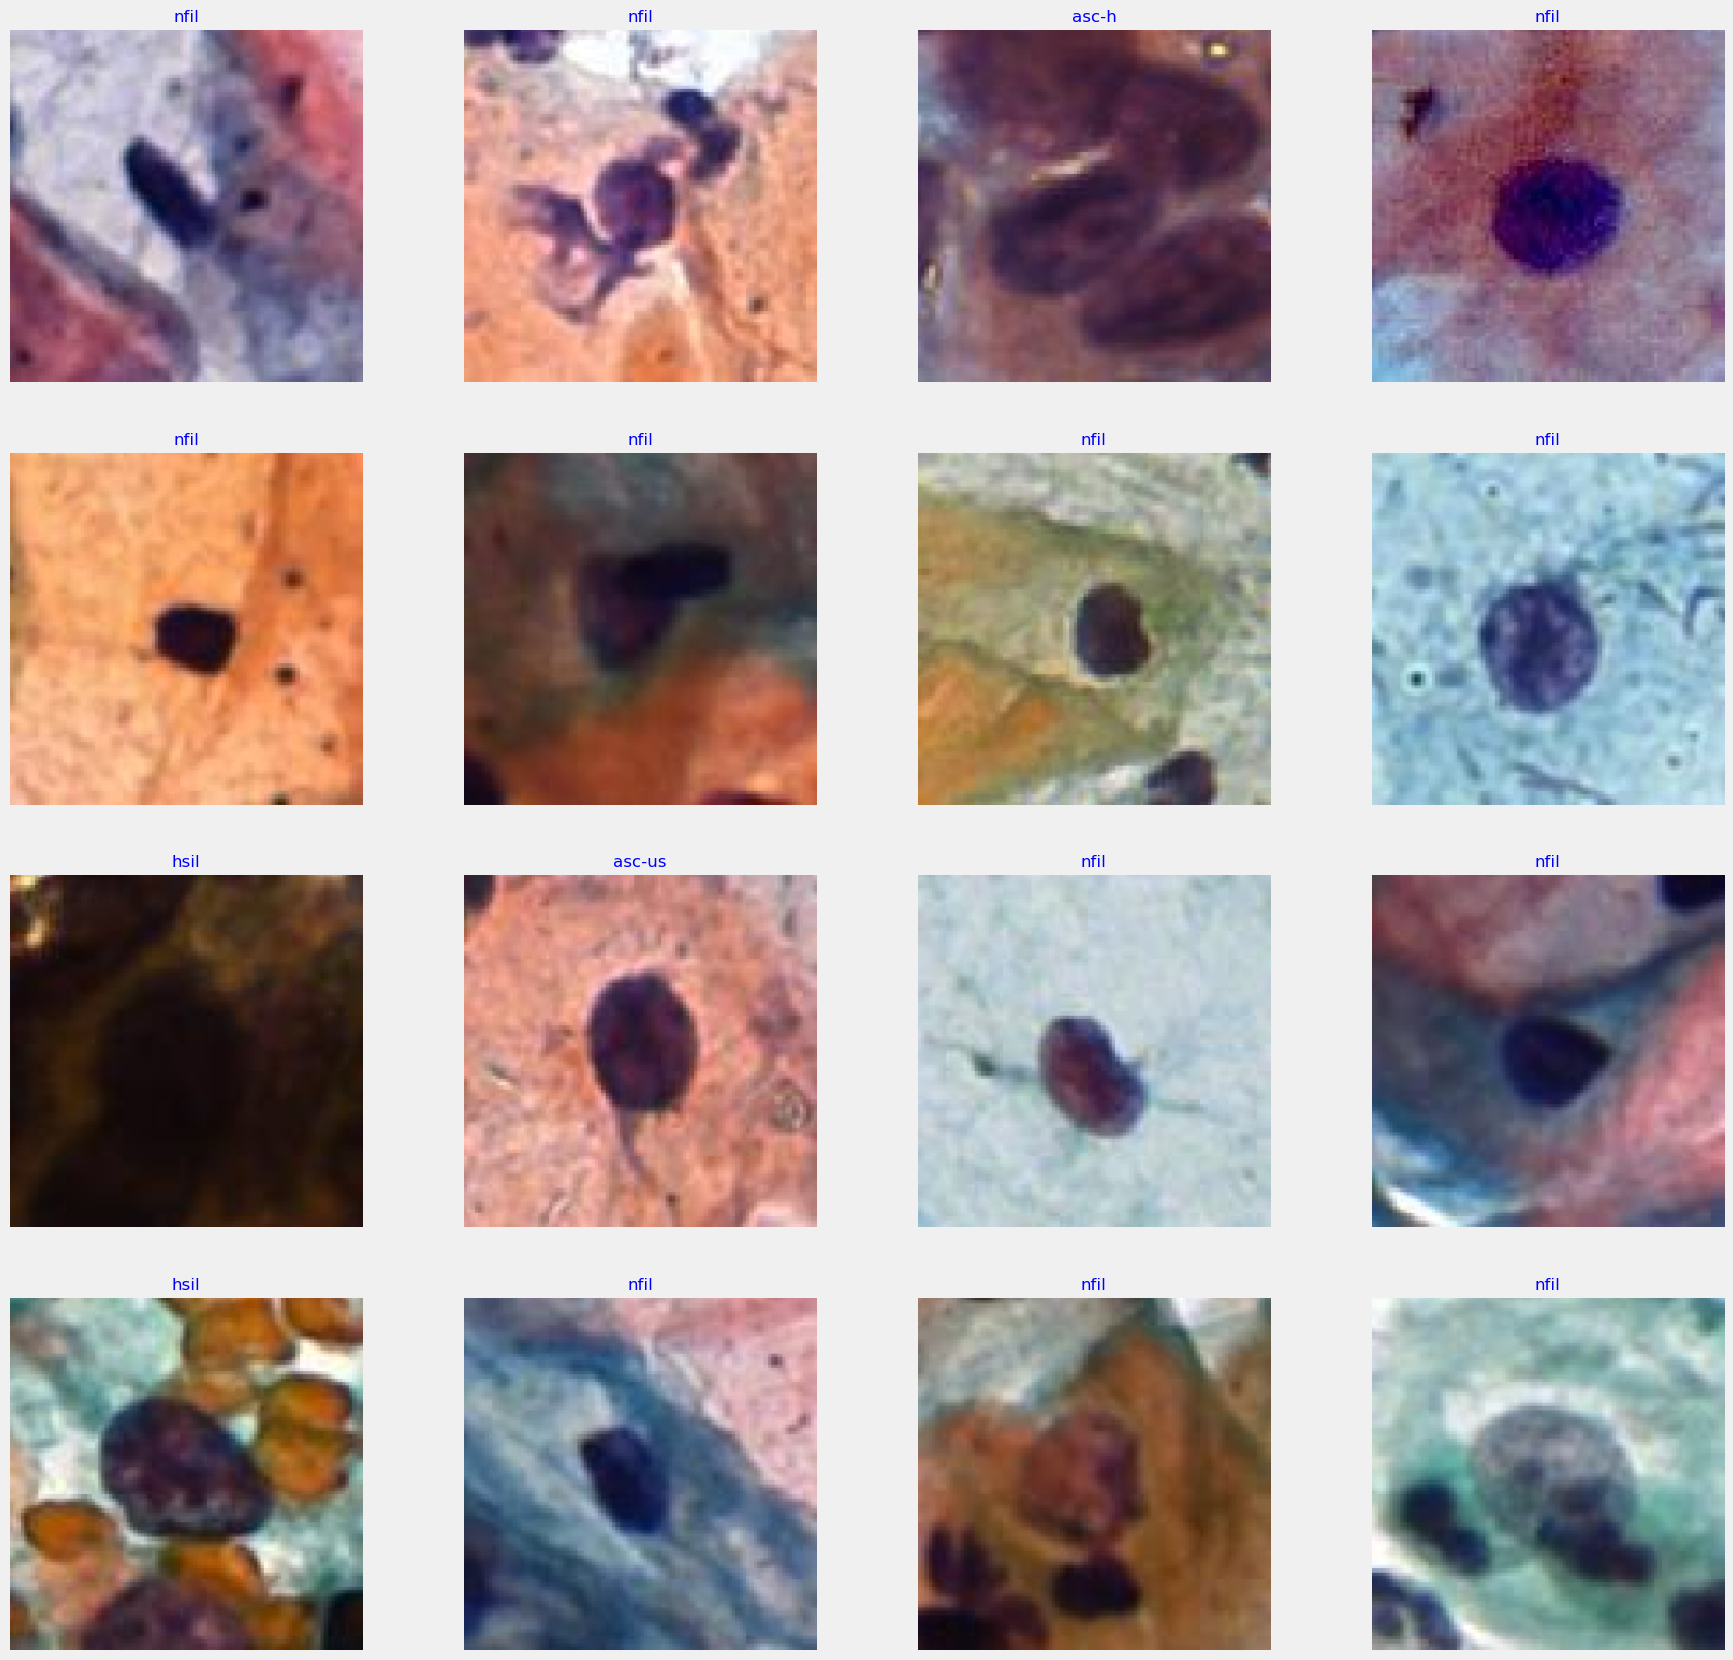

In [52]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

### Generic Model Creation

In [53]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 4384169 (16.72 MB)
Trainable params: 433

### Train model

In [54]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)


Epoch 1/20
271/271 [==============================] - 272s 958ms/step - loss: 6.8738 - accuracy: 0.6091 - val_loss: 2.9804 - val_accuracy: 0.6003
Epoch 2/20
271/271 [==============================] - 247s 911ms/step - loss: 2.0197 - accuracy: 0.7350 - val_loss: 1.4716 - val_accuracy: 0.7241
Epoch 3/20
271/271 [==============================] - 248s 913ms/step - loss: 1.2650 - accuracy: 0.7670 - val_loss: 1.0976 - val_accuracy: 0.7571
Epoch 4/20
271/271 [==============================] - 254s 936ms/step - loss: 1.0412 - accuracy: 0.7960 - val_loss: 1.2673 - val_accuracy: 0.7702
Epoch 5/20
271/271 [==============================] - 270s 997ms/step - loss: 1.0209 - accuracy: 0.8111 - val_loss: 1.9916 - val_accuracy: 0.7702
Epoch 6/20
271/271 [==============================] - 287s 1s/step - loss: 1.5056 - accuracy: 0.7890 - val_loss: 1.1272 - val_accuracy: 0.7786
Epoch 7/20
271/271 [==============================] - 320s 1s/step - loss: 1.1852 - accuracy: 0.8324 - val_loss: 1.1585 - val_a

### Display model performance

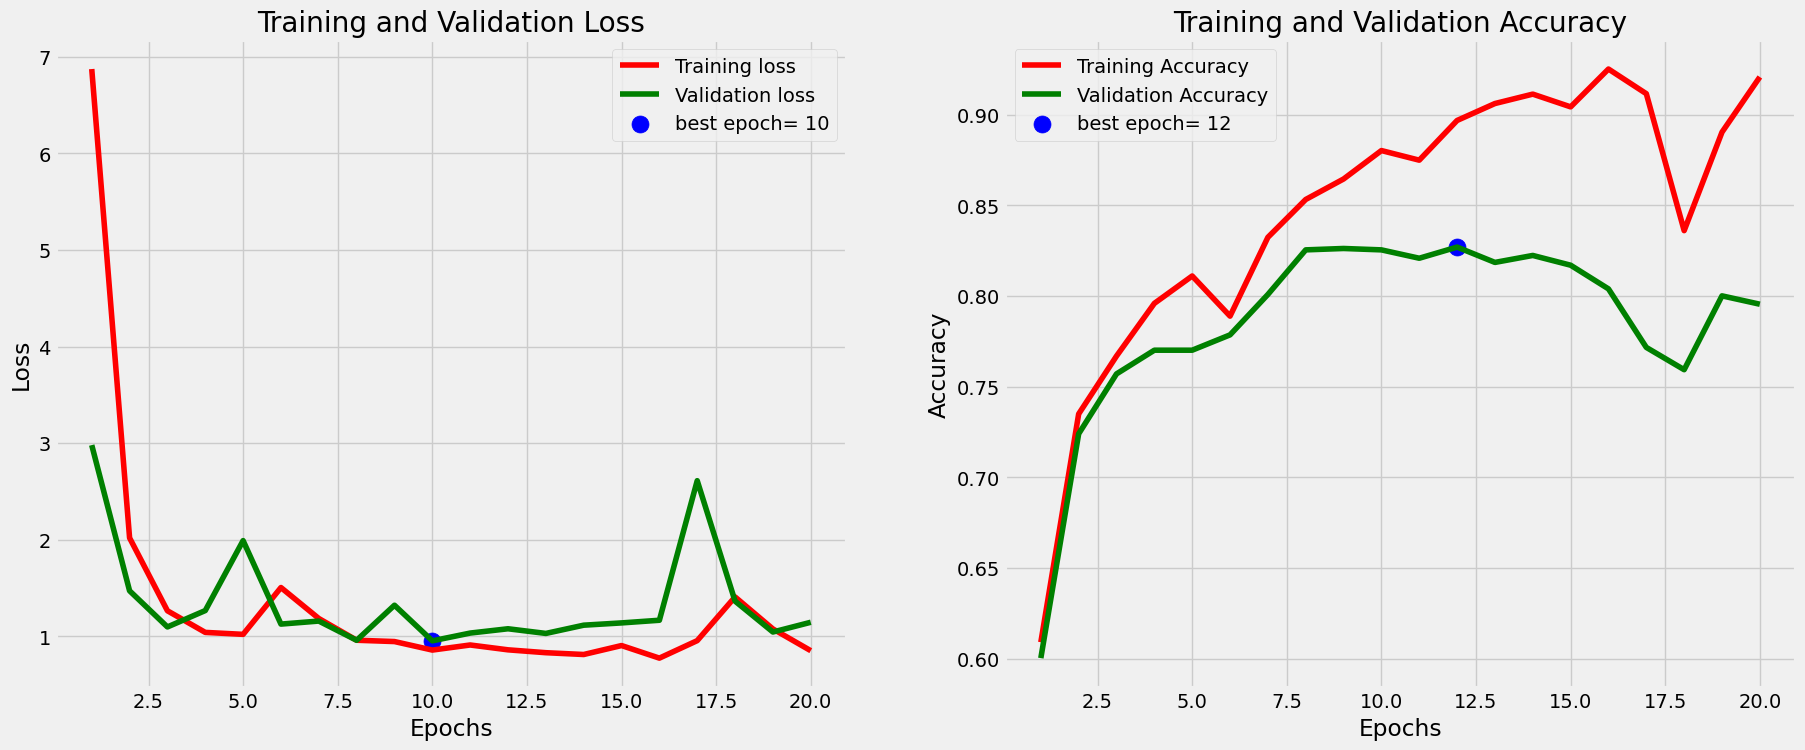

In [55]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

### Evaluate model on test data

In [56]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

14/14 [==============================] - 3s 225ms/step - loss: 1.0908 - accuracy: 0.8103
Train Loss:  0.7586656212806702
Train Accuracy:  0.9129464030265808
--------------------
Validation Loss:  1.153188943862915
Validation Accuracy:  0.7924107313156128
--------------------
Test Loss:  1.0907586812973022
Test Accuracy:  0.8102678656578064


### Get Predictions

In [57]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

/var/folders/52/dn6ssl5d3wg2d2bjf4mhlv040000gn/T/ipykernel_23508/2815406075.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


### Confusion Matrics and Classification Report

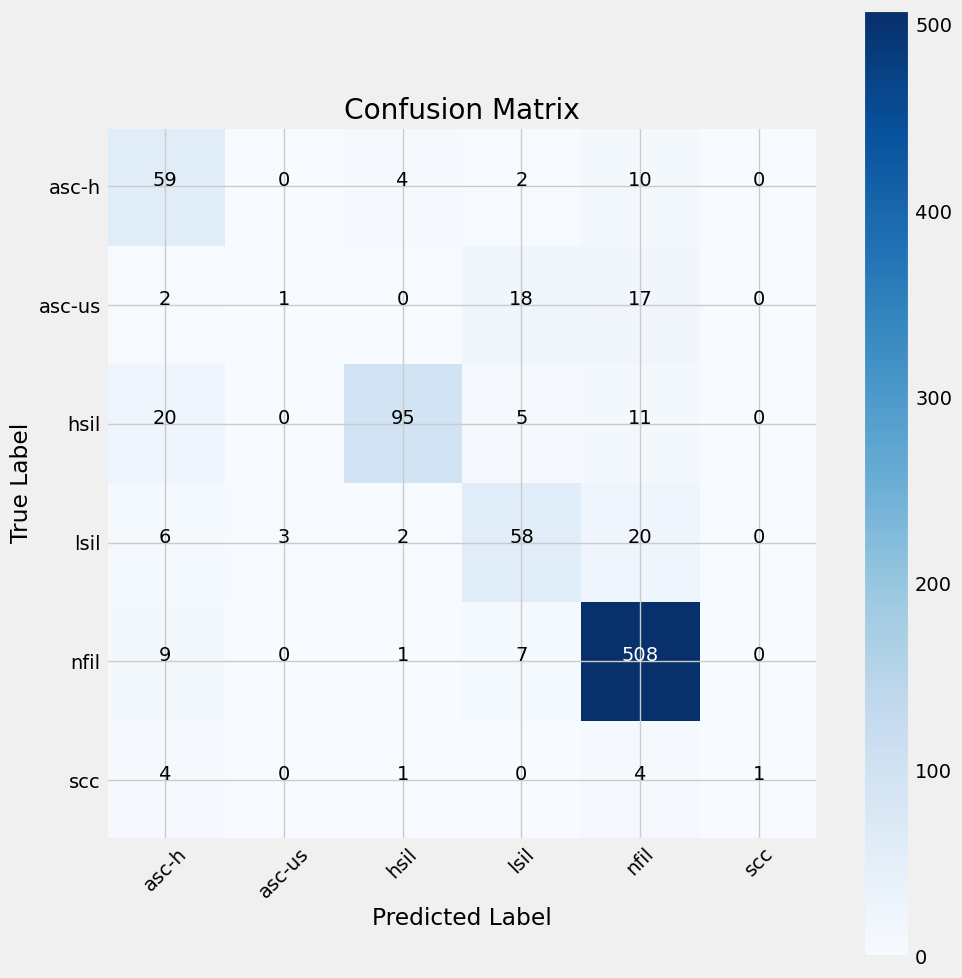

In [58]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [59]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       asc-h       0.59      0.79      0.67        75
      asc-us       0.25      0.03      0.05        38
        hsil       0.92      0.73      0.81       131
        lsil       0.64      0.65      0.65        89
        nfil       0.89      0.97      0.93       525
         scc       1.00      0.10      0.18        10

    accuracy                           0.83       868
   macro avg       0.72      0.54      0.55       868
weighted avg       0.82      0.83      0.81       868



In [60]:
model.save('6_weights.keras')

## Modelo Binario

### Read data and store it in dataframes

In [25]:
train_dir = 'train_test_images/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df.loc[train_df['labels'] != 'nfil', 'labels'] = 'positive'


In [26]:
test_dir = 'train_test_images/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
test_df.loc[test_df['labels'] != 'nfil', 'labels'] = 'positive'

### Split dataframe into valid and test

In [27]:
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

### Create image data generator

In [29]:
img_size = (224, 224)
batch_size = 32
channels = 3
img_shape = (img_size[0], img_size[1], channels)
epochs = 20

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8672 validated image filenames belonging to 2 classes.
Found 1301 validated image filenames belonging to 2 classes.
Found 868 validated image filenames belonging to 2 classes.


### Show sample from train data

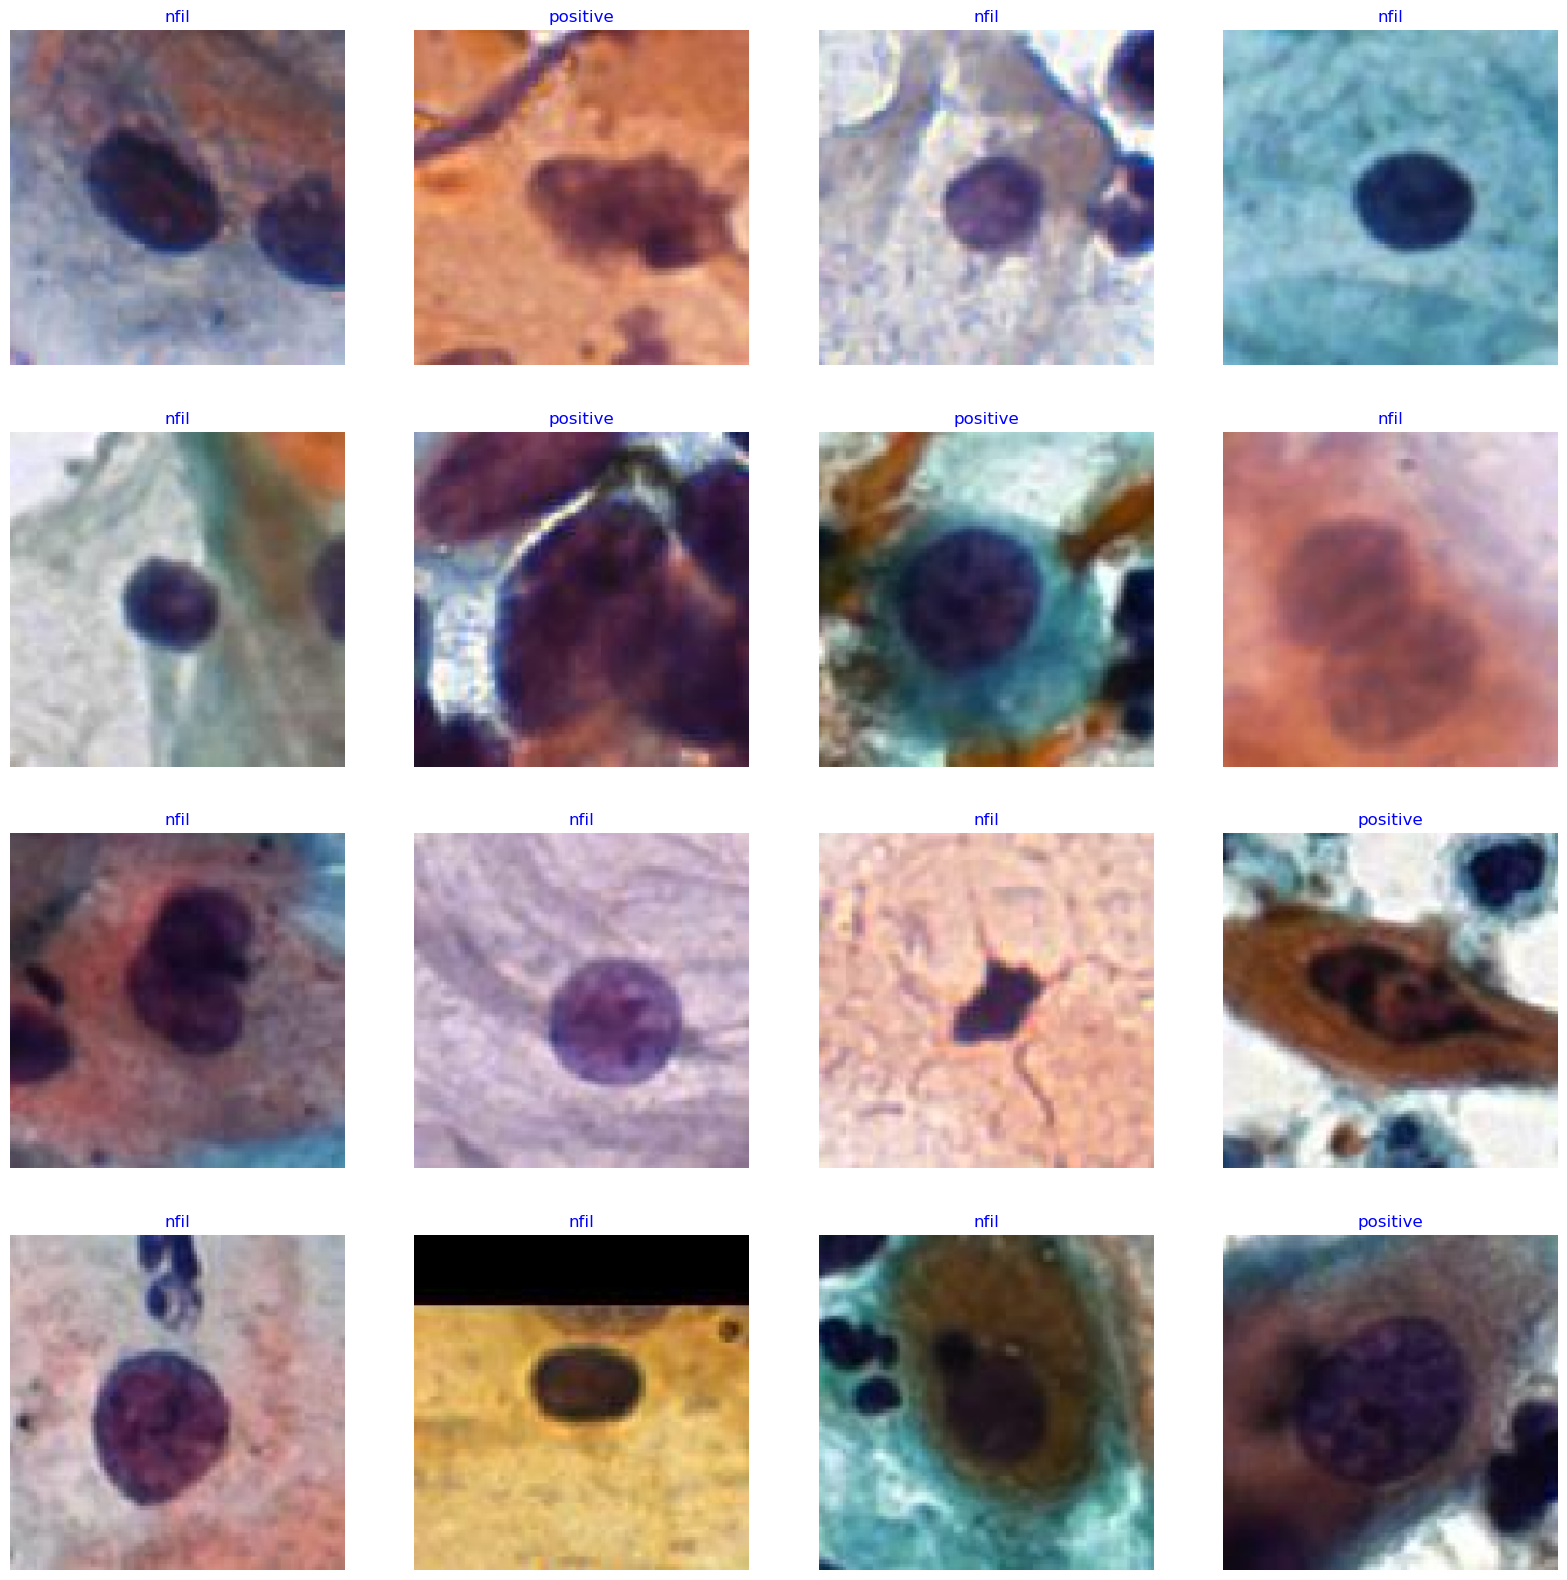

In [30]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

### Generic Model Creation

In [31]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4383141 (16.72 MB)
Trainable params: 433

### Train model

In [32]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
271/271 [==============================] - 266s 927ms/step - loss: 3.6122 - accuracy: 0.8145 - val_loss: 2.2906 - val_accuracy: 0.8663
Epoch 2/20
271/271 [==============================] - 250s 922ms/step - loss: 0.8167 - accuracy: 0.8923 - val_loss: 0.5083 - val_accuracy: 0.8993
Epoch 3/20
271/271 [==============================] - 257s 949ms/step - loss: 0.6679 - accuracy: 0.9011 - val_loss: 0.7788 - val_accuracy: 0.8547
Epoch 4/20
271/271 [==============================] - 262s 965ms/step - loss: 0.5726 - accuracy: 0.9226 - val_loss: 0.5023 - val_accuracy: 0.9070
Epoch 5/20
271/271 [==============================] - 261s 963ms/step - loss: 0.4899 - accuracy: 0.9300 - val_loss: 0.6595 - val_accuracy: 0.8970
Epoch 6/20
271/271 [==============================] - 261s 963ms/step - loss: 0.4934 - accuracy: 0.9350 - val_loss: 0.5629 - val_accuracy: 0.9085
Epoch 7/20
271/271 [==============================] - 273s 1s/step - loss: 0.5020 - accuracy: 0.9406 - val_loss: 0.7846 - va

### Display model performance

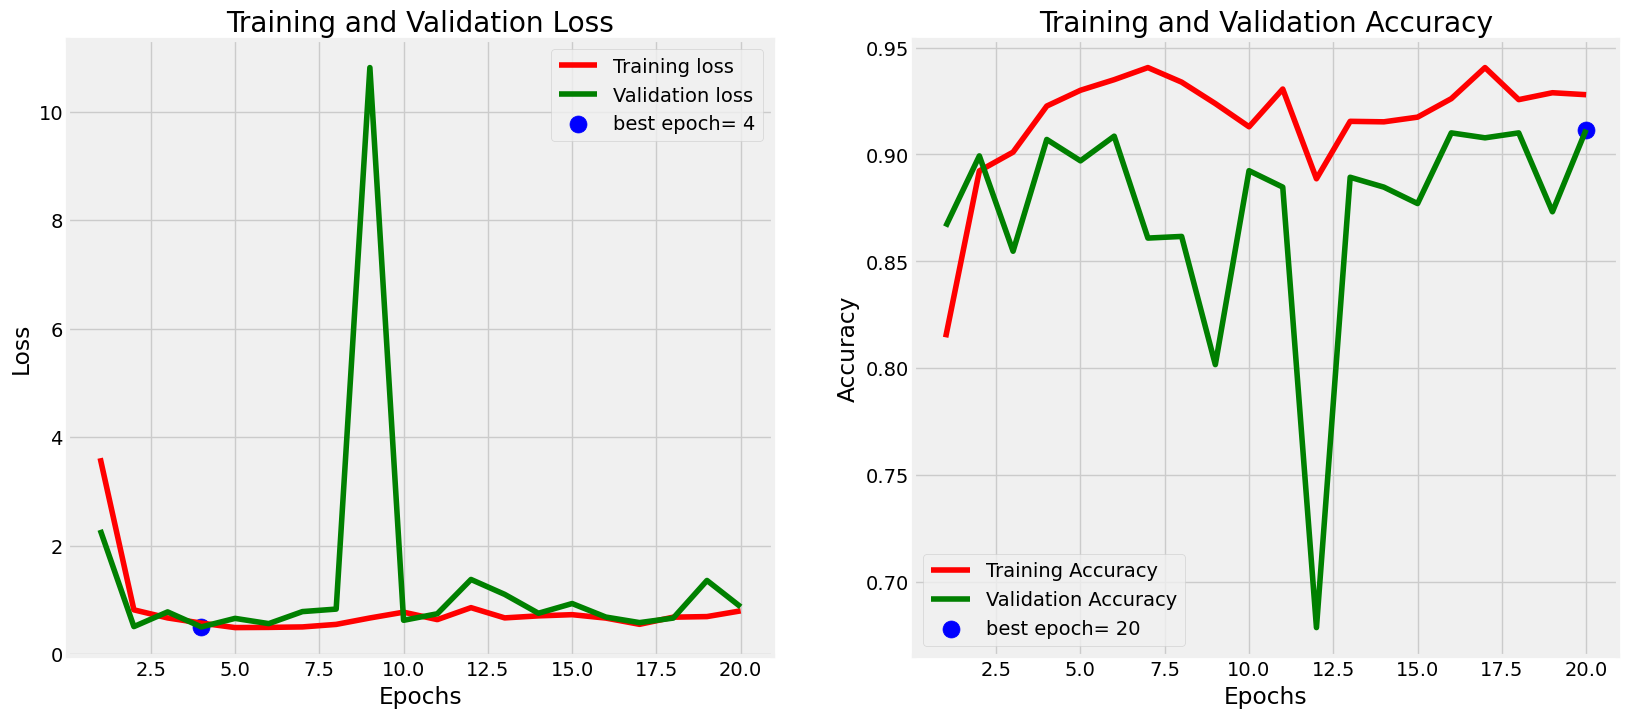

In [33]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

### Evaluate model on test data

In [34]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

14/14 [==============================] - 4s 297ms/step - loss: 0.8693 - accuracy: 0.9107
Train Loss:  0.8094502687454224
Train Accuracy:  0.953125
--------------------
Validation Loss:  0.845606803894043
Validation Accuracy:  0.921875
--------------------
Test Loss:  0.8693143129348755
Test Accuracy:  0.9107142686843872


### Get Predictions

In [35]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

/var/folders/52/dn6ssl5d3wg2d2bjf4mhlv040000gn/T/ipykernel_23508/2815406075.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


### Confusion Matrics and Classification Report

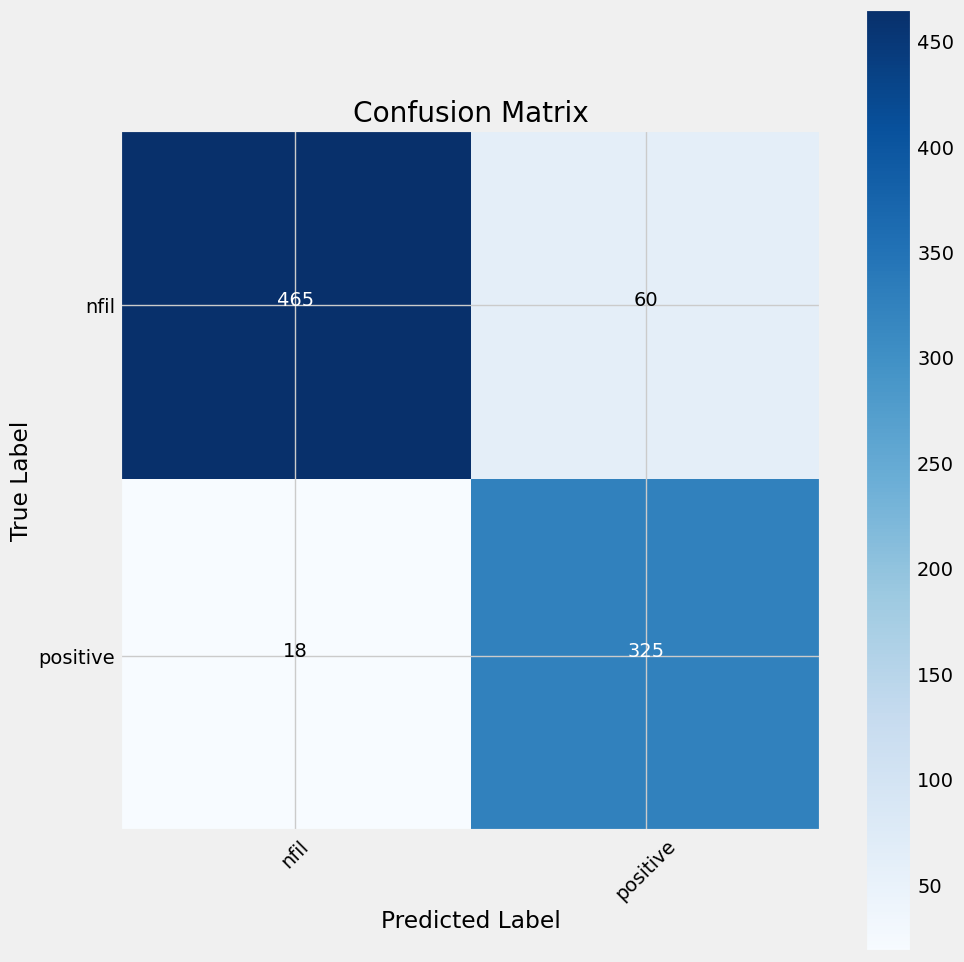

In [36]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [37]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

        nfil       0.96      0.89      0.92       525
    positive       0.84      0.95      0.89       343

    accuracy                           0.91       868
   macro avg       0.90      0.92      0.91       868
weighted avg       0.92      0.91      0.91       868



In [38]:
model.save('binary_weights.keras')

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.covariance import LedoitWolf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

def mahalanobis_distance(x, mean, inv_covariance_matrix):
    x_minus_mean = x - mean
    return np.sqrt(np.dot(np.dot(x_minus_mean, inv_covariance_matrix), x_minus_mean.T))

def predict_mahalanobis(data, multiclass=False):
    classes = data["bethesda_system"].unique()

    class_covariance_matrices = {}
    class_means = {}
    for c in classes:
        class_data = data[data["bethesda_system"] == c].drop(["bethesda_system", "original_filename", "cell_id"], axis=1)
        covariance_matrix = LedoitWolf().fit(class_data).covariance_
        class_covariance_matrices[c] = np.linalg.inv(covariance_matrix)
        class_means[c] = np.mean(class_data, axis=0)

    predicted_labels = []
    for _, sample in data.iterrows():
        distances = {c: mahalanobis_distance(sample[3:], class_means[c], class_covariance_matrices[c]) for c in classes}
        predicted_label = min(distances, key=distances.get)
        predicted_labels.append(predicted_label)

    # Avaliação da acurácia
    accuracy = accuracy_score(data["bethesda_system"], predicted_labels)
    print(f'Acurácia: {accuracy * 100:.2f}%')

    conf_matrix = confusion_matrix(data["bethesda_system"], predicted_labels, labels=classes)
    df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

    # Criação do diretório se não existir
    os.makedirs('confusion_matriz_mahalanobis', exist_ok=True)

    if multiclass:
        df.to_csv('confusion_matriz_mahalanobis/matriz_confusao_multiclass.csv', index=False)
    else:
        df.to_csv('confusion_matriz_mahalanobis/matriz_confusao_binary.csv', index=False)

def main():
    characteristics_df = pd.read_csv('characteristics.csv')
    train, test = train_test_split(characteristics_df, test_size=0.2, random_state=48, shuffle=True, stratify=characteristics_df['bethesda_system'])

    print("Classificação Binária:")
    predict_mahalanobis(train)
    
    print("\nClassificação Multiclasse:")
    predict_mahalanobis(test, multiclass=True)

if __name__ == "__main__":
    main()
